In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cluster import HDBSCAN
import seaborn as sns
import re

from skimage import io, color, filters, measure, morphology

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torchvision.transforms import Compose, Resize, ToTensor, CenterCrop

from tqdm import tqdm
import json

from key_finder import KeyFinder

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Found 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

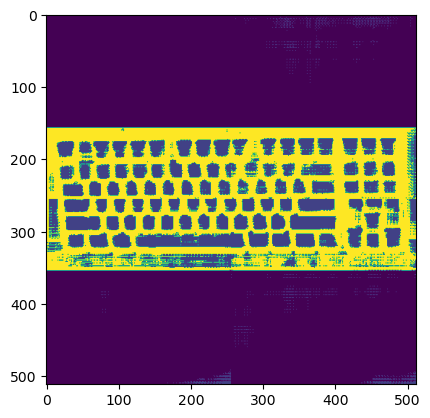

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
IMG_SIZE = 512
img_dir = "../real_testing"

def mask_to_closest_one_hot(mask, unique_values):
    mask_array = np.array(mask, dtype=np.float32)  # Shape: (IMAGE_SIZE, IMAGE_SIZE)
    mask_tensor = torch.tensor(mask_array).unsqueeze(0)  # Shape: (1, IMAGE_SIZE, IMAGE_SIZE)
    unique_tensor = torch.tensor(unique_values, dtype=torch.float32).view(-1, 1, 1)  # Shape: (3, 1, 1)
    distances = torch.abs(mask_tensor - unique_tensor)  # Shape: (3, IMAGE_SIZE, IMAGE_SIZE)
    closest_indices = torch.argmin(distances, dim=0)  # Shape: (IMAGE_SIZE, IMAGE_SIZE)
    one_hot = torch.nn.functional.one_hot(closest_indices, num_classes=len(unique_values))  # Shape: (IMAGE_SIZE, IMAGE_SIZE, 3)
    one_hot = one_hot.permute(2, 0, 1).float()

    return one_hot

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        all_images = os.listdir(root_dir)
        self.images = [img for img in all_images if re.search("Image", img)]
        print(f"Found {len(self.images)} images")
        self.items = []
        loop = tqdm(self.images)
        for img_path in loop:
            image =  Image.open(os.path.join(self.root_dir, img_path)).convert("RGB")
            mask = Image.open(os.path.join(self.root_dir, self._get_mask_for_image(img_path))).convert("L")
            plt.imshow(mask)
            plt.show()
            if self.transform:
                image = self.transform(image)
            transform2 = Compose([ToTensor()])
            
            image = transform2(image)
            mask0 = np.array(mask)
            unique_values = np.unique(mask0)
            mask = mask_to_closest_one_hot(mask0, unique_values=unique_values)
            mask = mask.numpy()
            self.items.append((image, mask))


    def __len__(self):
        return len(self.images)

    def _get_mask_for_image(self, img):
        return img.replace("Image", "Segmentation")

    def __getitem__(self, idx):
        return self.items[idx]
    
transforms = Compose([
    CenterCrop(1080),
    Resize((IMG_SIZE, IMG_SIZE)),
])

def get_images(image_dir, transform = None, batch_size = 1, shuffle = True, pin_memory = True):
    dataset = ImageDataset(image_dir, transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return data_loader, data_loader 

train_loader, test_loader = get_images(img_dir, transforms, batch_size=1)

#ig, axes = plt.subplots(3, 2, figsize=(10, 15))
#masks = []
#
#for i, (img, mask) in enumerate(train_loader):
#    axes[i, 0].imshow(img[0].permute(1, 2, 0))
#    axes[i, 0].set_title(f'Image {i}')
#    axes[i, 1].imshow(mask[0].permute(1, 2, 0))
#    axes[i, 1].set_title(f'Mask {i}')
#    masks.append(mask.squeeze(0))
#
#print(masks[0].shape)
#
#plt.tight_layout()
#plt.show()


False
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instruct

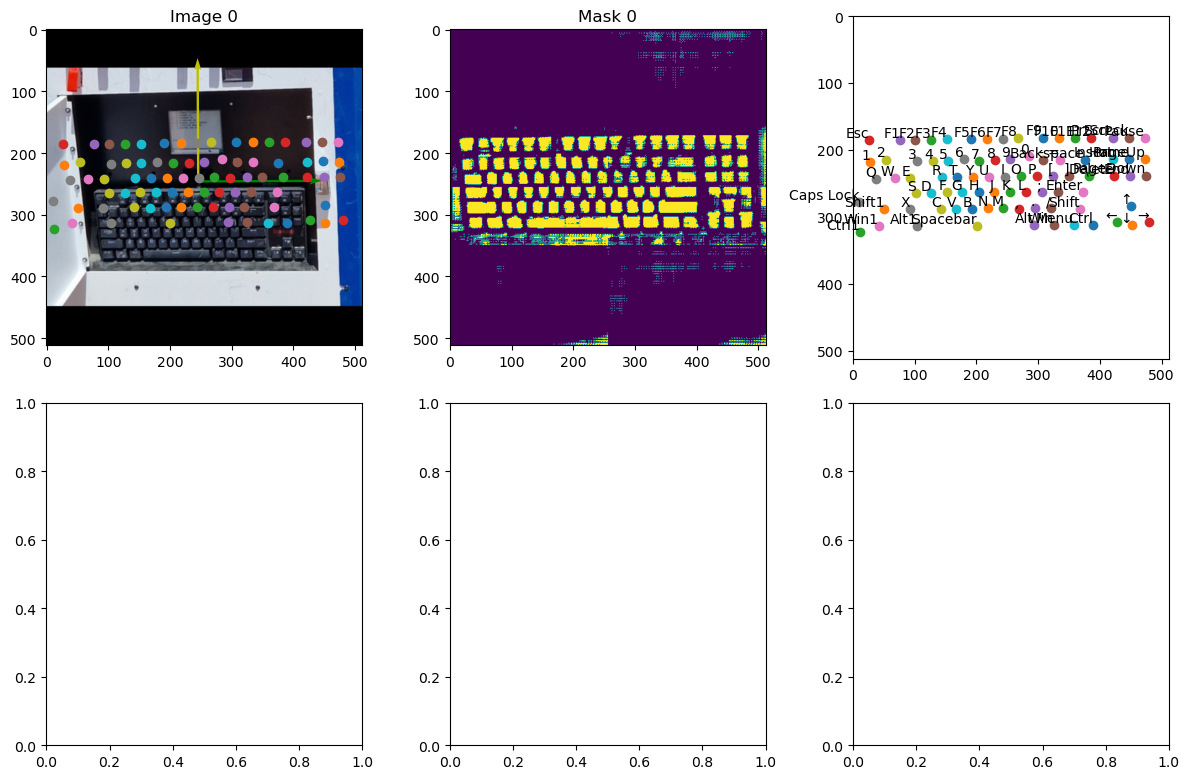

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, (img, mask) in enumerate(train_loader):
    indices = np.random.choice(img.size(0),img.size(0), replace=False)
    for j, idx in enumerate(indices):
        axes[j, 0].imshow(img[idx].permute(1, 2, 0))
        axes[j, 0].set_title(f'Image {idx}')
        axes[j, 1].set_title(f'Mask {idx}')
        keys = mask[idx][1,:].numpy().astype(np.uint8)
        #noise = np.zeros_like(keys)
        #ones_indices = np.random.choice(np.arange(keys.size), size=5, replace=False)
        #noise.flat[ones_indices] = 1
        #keys = keys + noise
        axes[j,1].imshow(keys)
        try:
            kf = KeyFinder(min_keys=50, 
                           probability_threshold=0.8,
                           min_key_size=100,
                           key_displacement_distance=1e-2,
                           input_missing_keys=False,
                           use_gauss=False,
                           max_cluster_size=None,
                           check_space_eccentricity= True,
                           min_eccentricity = 0.2,
                           cluster_epsilon=np.inf)
            letters = kf.find(keys)
            middle_x, middle_y = np.mean(kf.centers[:, 0]), np.mean(kf.centers[:, 1])
            axes[j, 0].quiver([middle_x, middle_x], 
                              [middle_y, middle_y], 
                              [200*vec[0] for vec in kf.base2], 
                              [200*vec[1] for vec in kf.base2], 
                              color=['g', 'y'], scale=1, scale_units='xy', angles='xy')
        except Exception as e:
            print(e.with_traceback())
            continue

        rotate = 1
        for key, value in letters.items():
            x, y = value['coords'][0], value['coords'][1] 
            x = x*(kf.return_values[1] - kf.return_values[0]) + kf.return_values[0] 
            y = y*(kf.return_values[3] - kf.return_values[2]) + kf.return_values[2] 
            coords = np.matrix([x,y])
            inverse = np.transpose(np.matrix(kf.base2))
            coords = np.matmul(coords, inverse)
            
            x = coords[0,0] + np.mean(kf.centers[:,0])
            y = coords[0,1] + np.mean(kf.centers[:,1])
            x = x+ int(x<0)*img[idx].shape[2]
            y = y+ int(y<0)*img[idx].shape[1]
            
            axes[j,2].scatter(x, y, label=key)  # Plot point
            axes[j,0].scatter(x, y, label=key)  # Plot point
            axes[j,2].text(x, y, key, fontsize=10, ha='right', va='bottom')
            axes[j,2].set_xlim([0,img[idx].shape[2]])
            axes[j,2].set_ylim([0,img[idx].shape[1]])
            axes[j,2].invert_yaxis()
        print("Rotate",j,":", rotate)
        print(img[idx].shape)
    break

plt.tight_layout()
plt.show()